In [1]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
import os

The number of photons detected in a single pixel from an object of constant surface brightness $\mu$:

\begin{equation}
N_{photons, source} = 10^{\frac{\mu_{source} - Z_p + kX}{-2.5}} * A_{pix} * t_{exp}
\end{equation}

where $Z_p$ is the telescope zeropoint, $k$ is the atmospheric extinction term, $X$ is airmass, $A_{pix}$ is the area of a pixel, and $t_{exp}$ is the exposure time.

The number of photons from the sky background will then be (note we drop the airmass extinction):
\begin{equation}
N_{photons, sky} = 10^{\frac{\mu_{sky} - Z_p}{-2.5}} * A_{pix} * t_{exp}
\end{equation}

So the total SNR should be:

\begin{equation}
\frac{S}{N} = \frac{N_{photons, source}}{\sqrt{N_{photons, source} + N_{photons, sky} + RN^2}}
\end{equation}

where RN is the readnoise in electrons. 

In [2]:
def numphot(mu, zp, k, airmass, area_pix=100, t_exp=30.):
    result = 10.**((mu-zp+k*airmass)/(-2.5)) * area_pix * t_exp
    return result

In [3]:
numphot(22, 22, 0.126, np.array([1.0, 1.1, 1.2, 1.5]))

array([2671.29133078, 2640.47010429, 2610.00449158, 2520.70054172])

In [4]:
def surface_brightness_limit(zp, k, airmass, mu_sky, rn=8.8, pixscale=0.2,
                             nsigma=3., t_exp=30., tot_area=100.):
    """
    Parameters
    ---------
    rm : float (8.8)
        Readnoise in electrons
    pixscale : float (0.2)
        Arcseconds per pixel
    t_exp : float (30.)
        Exposure time (seconds)
    tot_area : float (100)
        The total area measuring over (sq arcsec)
        
    Returns
    -------
    surface brightness limit in mags/sq arcsec
    """
    pix_area = pixscale**2
    n_pix = tot_area/pix_area
    snr_per_pix = nsigma/np.sqrt(n_pix)
    # This step might be what's causing things to be painfully slow. Could just compute in 
    # each of the source-limited, sky-limited, and readnoise-limited case and take the faintest.
    f = lambda mu: snr_per_pix**2 * ((pix_area * t_exp)*10.**((mu-zp+k*airmass)/(-2.5)) + (pix_area * t_exp)*10.**((mu_sky-zp)/(-2.5)) + rn**2) - pix_area**2*t_exp**2*10.**((mu-zp+k*airmass)/(-2.5))
    # Just use the sky brightness as an initial guess
    result = fsolve(f, np.array(mu_sky))
    
    return result

In [5]:
def surface_brightness_limit_approx(zp, k, airmass, mu_sky, rn=8.8, pixscale=0.2,
                             nsigma=3., t_exp=30., tot_area=100.):
    """Like surface_brightness_limit, but let's just analytically solve for 
    the limiting cases since that should be much faster
    
    Parameters
    ---------
    rm : float (8.8)
        Readnoise in electrons
    pixscale : float (0.2)
        Arcseconds per pixel
    t_exp : float (30.)
        Exposure time (seconds)
    tot_area : float (100)
        The total area measuring over (sq arcsec)
        
    Returns
    -------
    surface brightness limit in mags/sq arcsec
    """
    
    n_pix = tot_area/pixscale
    
    # Sky limited case
    mu_sky_lim = (mu_sky - zp)/2.5 -2.5*np.log10(nsigma*(tot_area*t_exp)**-0.5) + zp -k*airmass
    
    # Source limited case
    mu_source_lim = -2.5*np.log10(nsigma**2/(tot_area*t_exp)) + zp -k*airmass
    
    # Readnoise limited case
    mu_rn_lim = -2.5*np.log10(nsigma*rn/(tot_area * t_exp)*n_pix**0.5) + zp - k*airmass
    
    result = np.vstack([mu_sky_lim, mu_source_lim, mu_rn_lim])
    result = np.min(result, axis=0)
    
    
    return result

In [6]:
surface_brightness_limit(28.156, 0.126, 1.0, 21.197, nsigma=3)

array([27.26533632])

In [7]:
#surface_brightness_limit_approx(28.156, 0.126, 1.0, 21.197, nsigma=3)
#surface_brightness_limit_approx(28.156, 0.126, np.array([1.0, 1.5, 2.0, 2.5]), 21.197, nsigma=3)
#surface_brightness_limit_approx(28.156, 0.126, 1.0, np.array([18,19,20,21.197]), nsigma=3)
surface_brightness_limit_approx(28.156, 0.126, 1.0, 21.197, nsigma=3, t_exp=np.array([1,5,10,20, 30]))


array([26.10227768, 27.42730937, 27.80359686, 28.17988436, 28.39999843])

In [8]:
class SurfaceBrightLimitMetric(maf.BaseMetric):
    """Gaussian limit, ignoring systematic errors in photometry
    """
    def __init__(self, pixscale=0.2, nsigma=3., t_exp=30., tot_area=100.,
                 filterCol='filter', units='mag/sq arcsec', airmassCol='airmass',
                 exptimeCol='visitExposureTime', metricName='SurfaceBrightLimit', 
                 skybrightnessCol='skyBrightness', nexpCol='numExposures', zpt=None, kAtm=None,
                 readnoise=8.8, approx=False,
                 **kwargs):
        super().__init__(col=[filterCol, airmassCol,
                              exptimeCol, skybrightnessCol, nexpCol],
                         units=units, metricName=metricName, **kwargs)
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.exptimeCol = exptimeCol
        self.skybrightnessCol = skybrightnessCol
        self.nexpCol = nexpCol
        
        self.readnoise = readnoise
        self.pixscale = pixscale
        self.nsigma = nsigma
        self.tot_area = tot_area
        
        self.approx = approx
        
        # Load up the computed telescope values for zeropoints, etc.
        if zpt is None:
            syseng = rsUtils.SysEngVals()
            self.zpt = syseng.Zp_t
            self.kAtm = syseng.kAtm
        else:
            self.zpt = zpt
            self.kAtm = kAtm
    
    def run(self, dataSlice, slicePoint):
        filtername = np.unique(dataSlice[self.filterCol])
        if np.size(filtername) > 1:
            ValueError('Can only coadd depth in single filter, got filters %s' % filtername)
        filtername = filtername[0]
        
        # Scale up readnoise if the visit was split into multiple snaps
        readnoise = self.readnoise * np.sqrt(dataSlice[self.nexpCol])
        
        if self.approx:
            # Use the sky-limited approximation
            sb_per_visit =  surface_brightness_limit_approx(self.zpt[filtername], self.kAtm[filtername],
                                                 dataSlice[self.airmassCol], dataSlice[self.skybrightnessCol],
                                                 rn=readnoise, pixscale=self.pixscale,
                                                 nsigma=self.nsigma, t_exp=dataSlice[self.exptimeCol],
                                                 tot_area=self.tot_area)
        else:
            sb_per_visit =  surface_brightness_limit(self.zpt[filtername], self.kAtm[filtername],
                                                     dataSlice[self.airmassCol], dataSlice[self.skybrightnessCol],
                                                     rn=readnoise, pixscale=self.pixscale,
                                                     nsigma=self.nsigma, t_exp=dataSlice[self.exptimeCol],
                                                     tot_area=self.tot_area)
        
        coadd_sb_limit = 1.25 * np.log10(np.sum(10**(0.8 * sb_per_visit)))
        return coadd_sb_limit
        

In [9]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)


In [10]:
bundleList = []
slicer = maf.slicers.HealpixSlicer(nside=16)

summary_stats = [maf.metrics.MedianMetric()]

for filtername in 'ugrizy':
    metric = SurfaceBrightLimitMetric()
    # Select all the visits
    sql = 'filter="%s"' % filtername
    #bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
    
    metric = SurfaceBrightLimitMetric(approx=True, metricName='SurfaceBrightLimit_approx')
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


Querying database SummaryAllProps with constraint filter="u" for columns ['fieldDec', 'visitExposureTime', 'airmass', 'fieldRA', 'filter', 'skyBrightness', 'numExposures', 'rotSkyPos']
Found 130925 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_approx_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="y" for columns ['fieldDec', 'visitExposureTime', 'airmass', 'fieldRA', 'filter', 'skyBrightness', 'numExposures', 'rotSkyPos']
Found 404071 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_approx_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" for columns ['fieldDec', 'visitExposureTime', 'airmass', 'fieldRA', 'filter', 'skyBrightness', 'numExposures', 'rotSkyPos']
Found 397742 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimi

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="y"" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 275 bins, returning 200
  warnings.warn('Optimal bin calculation 

Plotting complete.
Plotting figures with "filter="z"" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="i"" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="g"" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.


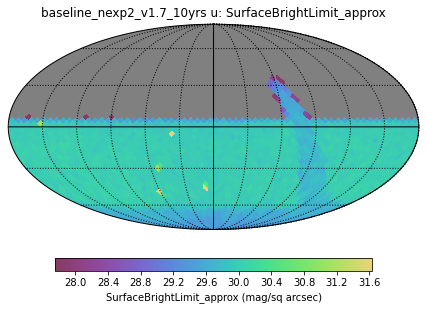

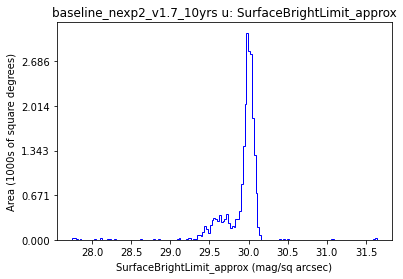

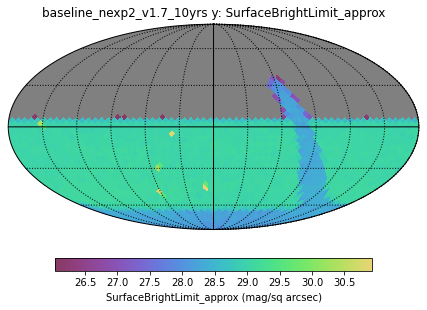

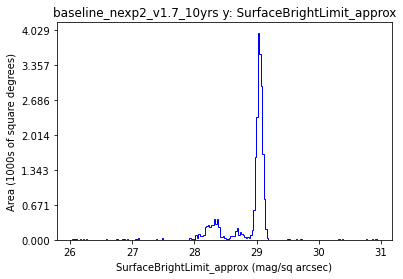

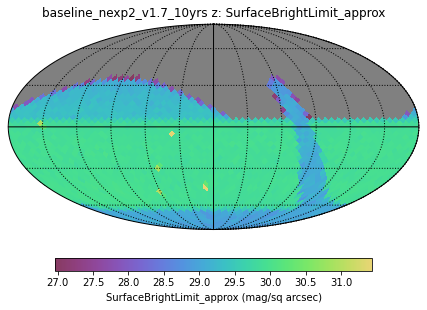

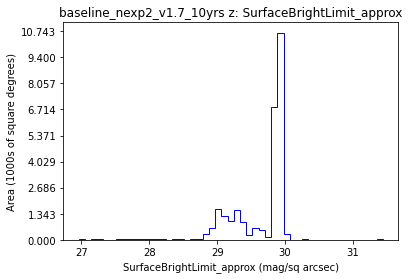

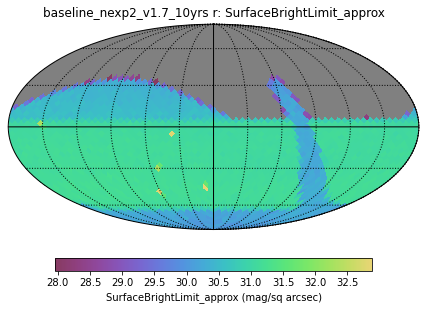

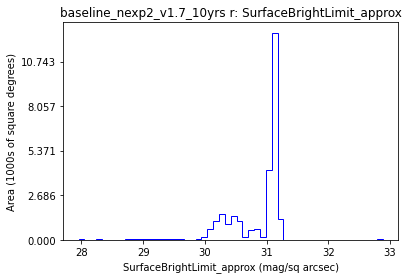

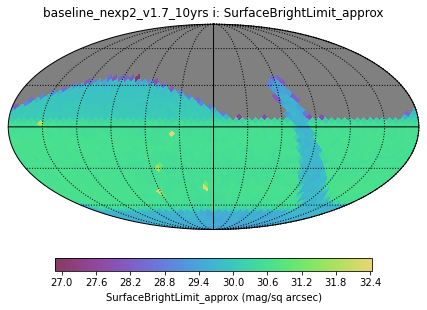

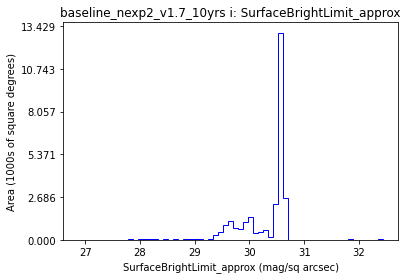

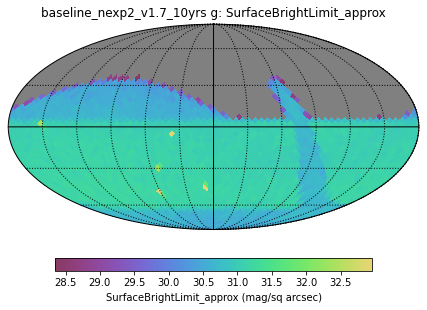

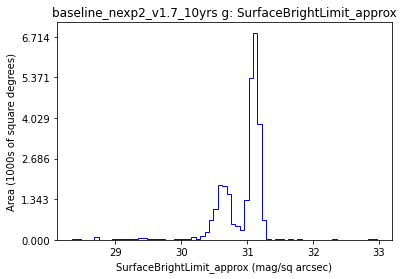

In [11]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [12]:
for b in bundleList:
    print(b.constraint, b.summaryValues)

filter="u" {'Median': 29.9826280782195}
filter="g" {'Median': 31.067084813517717}
filter="r" {'Median': 31.085109771587753}
filter="i" {'Median': 30.541480457216412}
filter="z" {'Median': 29.871011729417056}
filter="y" {'Median': 29.030423382089594}


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter="i" and night < 730 for columns ['fieldDec', 'visitExposureTime', 'airmass', 'fieldRA', 'filter', 'skyBrightness', 'numExposures', 'rotSkyPos']
Found 84873 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_approx_i_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and night < 730 for columns ['fieldDec', 'visitExposureTime', 'airmass', 'fieldRA', 'filter', 'skyBrightness', 'numExposures', 'rotSkyPos']
Found 83137 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_approx_r_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="y" and night < 730 for columns ['fieldDec', 'visitExposureTime

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="r" and night < 730" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="y" and night < 730" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="z" and night < 730" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="u" and night < 730" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.
Plotting figures with "filter="g" and night < 730" constraint now.


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Plotting complete.


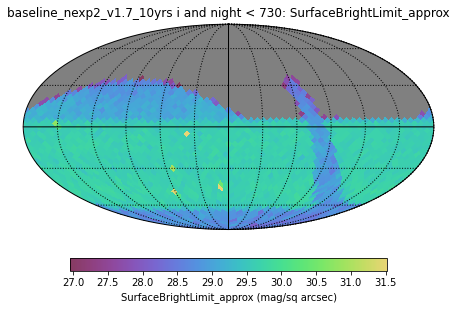

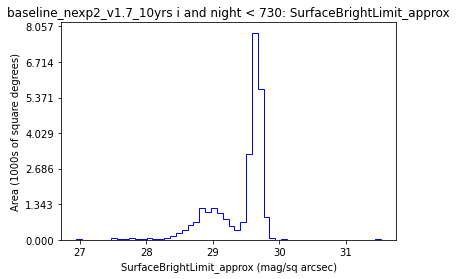

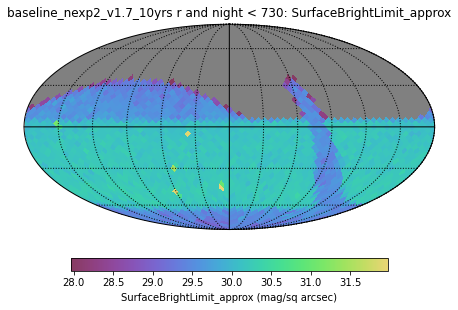

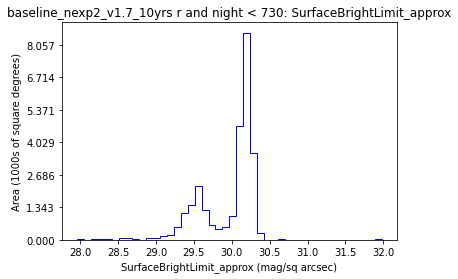

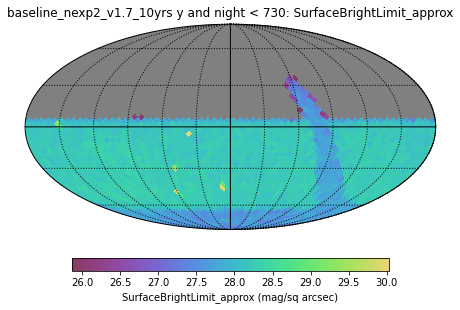

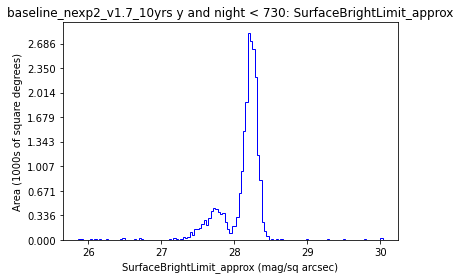

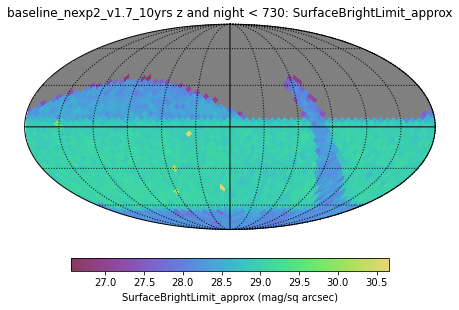

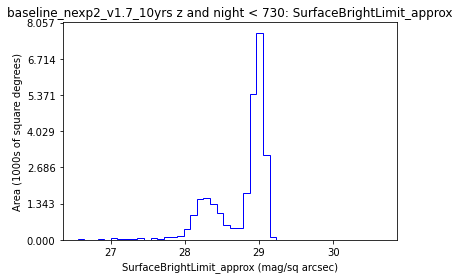

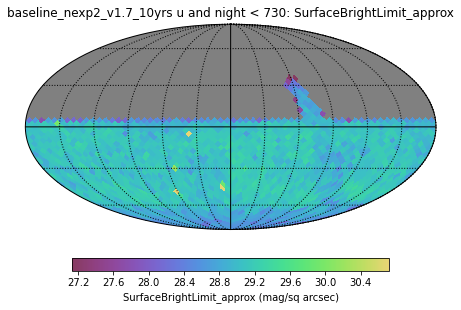

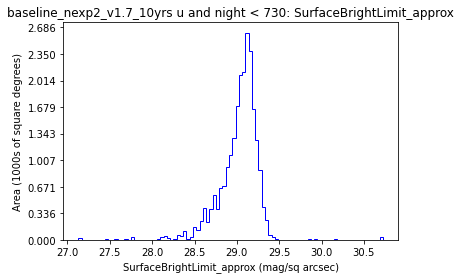

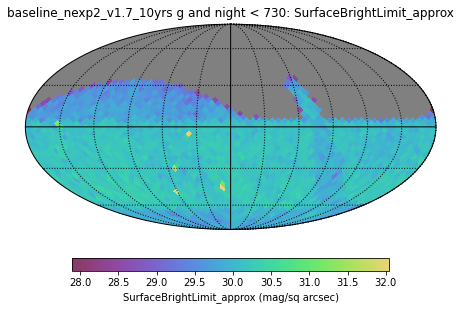

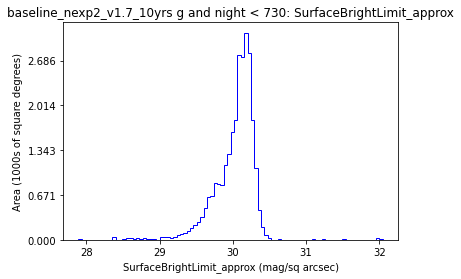

In [14]:
# Let's do it for the first two years and see if that scales reasonably
bundleList = []
slicer = maf.slicers.HealpixSlicer(nside=16)

summary_stats = [maf.metrics.MedianMetric()]

for filtername in 'ugrizy':
    metric = SurfaceBrightLimitMetric()
    # Select all the visits
    sql = 'filter="%s" and night < 730' % filtername
    #bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
    
    metric = SurfaceBrightLimitMetric(approx=True, metricName='SurfaceBrightLimit_approx')
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [15]:
for b in bundleList:
    print(b.constraint, b.summaryValues)

filter="u" and night < 730 {'Median': 29.063465330021963}
filter="g" and night < 730 {'Median': 30.086432783893702}
filter="r" and night < 730 {'Median': 30.135132368700365}
filter="i" and night < 730 {'Median': 29.602976661011176}
filter="z" and night < 730 {'Median': 28.932245901164283}
filter="y" and night < 730 {'Median': 28.19923103950325}
